# 03a – DistilBERT Fine-Tuning (BBC News) – Split 60/20/20

Ziel: Fine-Tuning von DistilBERT für Textklassifikation und Vergleich gegen Baseline und BERT.

**Split-Strategie:** 60% Train / 20% Validation / 20% Test

In [1]:
import time
import random
import numpy as np
import pandas as pd
from pathlib import Path

import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

## Seeds & Config

In [2]:
SEED = 42
SPLIT_NAME = "60-20-20"

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Split: {SPLIT_NAME}")

CUDA available: True
Device: cuda
Split: 60-20-20


## 1) CSV laden & Labels encoden

In [3]:
PROJECT_ROOT = Path.cwd().parent
CSV_PATH = PROJECT_ROOT / "data" / "processed" / "bbc_news.csv"

df = pd.read_csv(CSV_PATH, encoding="utf-8")
df.shape, df["label"].nunique()

((2225, 5), 5)

In [4]:
labels_sorted = sorted(df["label"].unique())
label2id = {lbl: i for i, lbl in enumerate(labels_sorted)}
id2label = {i: lbl for lbl, i in label2id.items()}

df["label_id"] = df["label"].map(label2id)

labels_sorted, label2id

(['business', 'entertainment', 'politics', 'sport', 'tech'],
 {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4})

## 2) Train/Validation/Test Split (60/20/20)

**Identisch zum BERT-Notebook für fairen Vergleich!**

In [5]:
X = df["text"].tolist()
y = df["label_id"].tolist()

# Erst Test-Set abspalten (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

# Dann Val-Set aus dem Rest (25% von 80% = 20% vom Gesamtdataset)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    random_state=SEED,
    stratify=y_temp
)

print(f"Split: {SPLIT_NAME}")
print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))
print(f"Actual Split: {len(X_train)/len(X)*100:.1f}% / {len(X_val)/len(X)*100:.1f}% / {len(X_test)/len(X)*100:.1f}%")

Split: 60-20-20
Train: 1335 Val: 445 Test: 445
Actual Split: 60.0% / 20.0% / 20.0%


## 3) Tokenization + Dataset

In [6]:
MODEL_NAME = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
MAX_LEN = 256  # 256 ist oft ein guter Tradeoff bei News-Texten

def tokenize_texts(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=MAX_LEN
    )

In [8]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenize_texts(texts)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_ds = TextDataset(X_train, y_train)
val_ds   = TextDataset(X_val, y_val)
test_ds  = TextDataset(X_test, y_test)

len(train_ds), len(val_ds), len(test_ds)

(1335, 445, 445)

## 4) Model + Training

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels_sorted),
    id2label=id2label,
    label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}

In [11]:
OUT_DIR = PROJECT_ROOT / "results" / f"distilbert_{SPLIT_NAME}"
OUT_DIR.mkdir(parents=True, exist_ok=True)

training_args = TrainingArguments(
    output_dir=str(OUT_DIR),
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    seed=SEED
)

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

start = time.time()
train_output = trainer.train()
elapsed = time.time() - start

print(f"Training time: {elapsed/60:.1f} minutes")
train_output

  0%|          | 0/252 [00:00<?, ?it/s]

{'loss': 1.1459, 'grad_norm': 2.6434710025787354, 'learning_rate': 1.6031746031746033e-05, 'epoch': 0.6}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.22794446349143982, 'eval_accuracy': 0.9662921348314607, 'eval_runtime': 0.631, 'eval_samples_per_second': 705.226, 'eval_steps_per_second': 22.187, 'epoch': 1.0}
{'loss': 0.3203, 'grad_norm': 5.1757659912109375, 'learning_rate': 1.2063492063492064e-05, 'epoch': 1.19}
{'loss': 0.1385, 'grad_norm': 0.6663268804550171, 'learning_rate': 8.095238095238097e-06, 'epoch': 1.79}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.1034516841173172, 'eval_accuracy': 0.9752808988764045, 'eval_runtime': 0.6282, 'eval_samples_per_second': 708.4, 'eval_steps_per_second': 22.287, 'epoch': 2.0}
{'loss': 0.0595, 'grad_norm': 0.31502217054367065, 'learning_rate': 4.126984126984127e-06, 'epoch': 2.38}
{'loss': 0.0734, 'grad_norm': 5.279867649078369, 'learning_rate': 1.5873015873015874e-07, 'epoch': 2.98}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.08891536295413971, 'eval_accuracy': 0.9797752808988764, 'eval_runtime': 0.6384, 'eval_samples_per_second': 697.024, 'eval_steps_per_second': 21.929, 'epoch': 3.0}
{'train_runtime': 22.6871, 'train_samples_per_second': 176.532, 'train_steps_per_second': 11.108, 'train_loss': 0.3450485934459028, 'epoch': 3.0}
Training time: 0.4 minutes


TrainOutput(global_step=252, training_loss=0.3450485934459028, metrics={'train_runtime': 22.6871, 'train_samples_per_second': 176.532, 'train_steps_per_second': 11.108, 'total_flos': 265280157734400.0, 'train_loss': 0.3450485934459028, 'epoch': 3.0})

## 5) Evaluation auf Validation Set

In [13]:
val_result = trainer.evaluate(val_ds)
acc_val = val_result["eval_accuracy"]
print(f"Validation Accuracy: {acc_val:.4f}")

  0%|          | 0/14 [00:00<?, ?it/s]

Validation Accuracy: 0.9798


## 6) Finale Evaluation auf Test-Set

In [14]:
pred = trainer.predict(test_ds)
test_logits = pred.predictions
test_labels = pred.label_ids
test_preds = np.argmax(test_logits, axis=-1)

acc_test = accuracy_score(test_labels, test_preds)

print("=" * 60)
print(f"FINALE TEST-SET EVALUATION (Split: {SPLIT_NAME})")
print("=" * 60)
print(f"Test Accuracy: {acc_test:.4f}")
print("\nClassification Report:\n")
print(classification_report(
    test_labels,
    test_preds,
    target_names=[id2label[i] for i in range(len(labels_sorted))]
))

  0%|          | 0/14 [00:00<?, ?it/s]

FINALE TEST-SET EVALUATION (Split: 60-20-20)
Test Accuracy: 0.9865

Classification Report:

               precision    recall  f1-score   support

     business       0.98      0.96      0.97       102
entertainment       1.00      1.00      1.00        77
     politics       0.98      0.98      0.98        84
        sport       1.00      1.00      1.00       102
         tech       0.98      1.00      0.99        80

     accuracy                           0.99       445
    macro avg       0.99      0.99      0.99       445
 weighted avg       0.99      0.99      0.99       445



## 7) Confusion Matrix

Saved: c:\CAS\cas-ml-document-classification\results\distilbert_60-20-20\confusion_matrix_distilbert-base-uncased_60-20-20.png


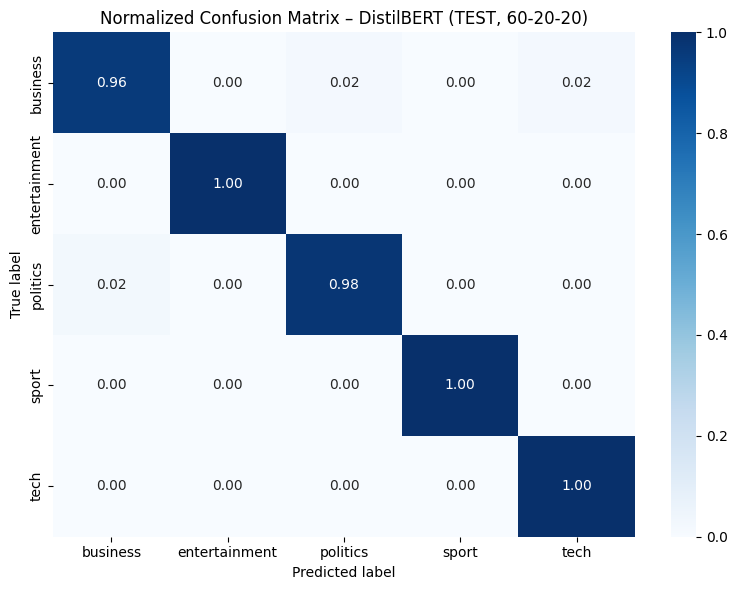

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(test_labels, test_preds, labels=list(range(len(labels_sorted))))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=[id2label[i] for i in range(len(labels_sorted))],
            yticklabels=[id2label[i] for i in range(len(labels_sorted))])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title(f"Normalized Confusion Matrix – DistilBERT (TEST, {SPLIT_NAME})")
plt.tight_layout()

fig_path = OUT_DIR / f"confusion_matrix_{MODEL_NAME.replace('/', '_')}_{SPLIT_NAME}.png"
plt.savefig(fig_path, dpi=300)
print("Saved:", fig_path)
plt.show()

## 8) Model speichern

In [16]:
model_dir = OUT_DIR / "best_model"
trainer.save_model(str(model_dir))
tokenizer.save_pretrained(str(model_dir))

print("Saved model to:", model_dir)

Saved model to: c:\CAS\cas-ml-document-classification\results\distilbert_60-20-20\best_model


## 9) Ergebnisse speichern (für Vergleich)

In [17]:
results_dict = {
    "model": f"DistilBERT ({MODEL_NAME})",
    "split": SPLIT_NAME,
    "train_size": len(X_train),
    "val_size": len(X_val),
    "test_size": len(X_test),
    "val_accuracy": acc_val,
    "test_accuracy": acc_test,
    "test_macro_f1": f1_score(test_labels, test_preds, average="macro"),
    "test_macro_precision": precision_score(test_labels, test_preds, average="macro"),
    "test_macro_recall": recall_score(test_labels, test_preds, average="macro"),
    "training_time_min": round(elapsed / 60, 2),
    "max_len": MAX_LEN,
    "epochs": 3,
    "learning_rate": 2e-5
}

results_df = pd.DataFrame([results_dict])
results_path = PROJECT_ROOT / "results" / f"distilbert_results_{SPLIT_NAME}.csv"
results_df.to_csv(results_path, index=False)
print(f"✅ Ergebnisse gespeichert: {results_path}")
results_df

✅ Ergebnisse gespeichert: c:\CAS\cas-ml-document-classification\results\distilbert_results_60-20-20.csv


,model,split,train_size,val_size,test_size,val_accuracy,test_accuracy,test_macro_f1,test_macro_precision,test_macro_recall,training_time_min,max_len,epochs,learning_rate
0,DistilBERT (distilbert-base-uncased),60-20-20,1335,445,445,0.979775,0.986517,0.986828,0.98636,0.987395,0.39,256,3,0.00002
